In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [3]:
cares = pd.read_csv("../data/CARES_exclusion_cleaned.csv")
print(cares.shape)
cares.head()

(2167, 8)


,Unnamed: 0,GEO_ID,NAME,total_population,tract,N_corrected,CARES_exclusion,CARES_exclusion_c
0,0,1400000US36061000100,"Census Tract 1, New York County, New York",0,36061000100,3.679345,0.000000,0.000000
1,1,1400000US36061000201,"Census Tract 2.01, New York County, New York",2835,36061000201,1352.964425,0.522764,0.522764
2,2,1400000US36061000202,"Census Tract 2.02, New York County, New York",7764,36061000202,6075.198137,0.217517,0.217517
3,3,1400000US36061000500,"Census Tract 5, New York County, New York",0,36061000500,NaN,NaN,0.000000
4,4,1400000US36061000600,"Census Tract 6, New York County, New York",9731,36061000600,8625.930297,0.113562,0.113562


In [4]:
cares["CARES_exclusion_n"] = cares["total_population"] - cares["N_corrected"]
cares["rank"] = cares['CARES_exclusion_n'].rank()
# larger residual population leads to higher ranker and greater risk
cares["bin"] = pd.cut(cares["rank"], 5, labels=[1,2,3,4,5])
cares.head()

,Unnamed: 0,GEO_ID,NAME,total_population,tract,N_corrected,CARES_exclusion,CARES_exclusion_c,CARES_exclusion_n,rank,bin
0,0,1400000US36061000100,"Census Tract 1, New York County, New York",0,36061000100,3.679345,0.000000,0.000000,-3.679345,482.0,2
1,1,1400000US36061000201,"Census Tract 2.01, New York County, New York",2835,36061000201,1352.964425,0.522764,0.522764,1482.035575,1862.0,5
2,2,1400000US36061000202,"Census Tract 2.02, New York County, New York",7764,36061000202,6075.198137,0.217517,0.217517,1688.801863,1931.0,5
3,3,1400000US36061000500,"Census Tract 5, New York County, New York",0,36061000500,NaN,NaN,0.000000,NaN,NaN,NaN
4,4,1400000US36061000600,"Census Tract 6, New York County, New York",9731,36061000600,8625.930297,0.113562,0.113562,1105.069703,1663.0,4


In [5]:
file_path = "zip://../data/cb_2018_36_tract_500k.zip!cb_2018_36_tract_500k.shp"   # for windows
# file_path = "zip:../data/cb_2018_36_tract_500k.zip!cb_2018_36_tract_500k.shp"   # for mac maybe
tracks = gpd.read_file(file_path)

In [6]:
tracks.shape

(4906, 10)

In [7]:
tracksNYC = tracks.join(cares.set_index("GEO_ID"), on = "AFFGEOID", how = "right", rsuffix='d')
tracksNYC.shape

(2167, 20)

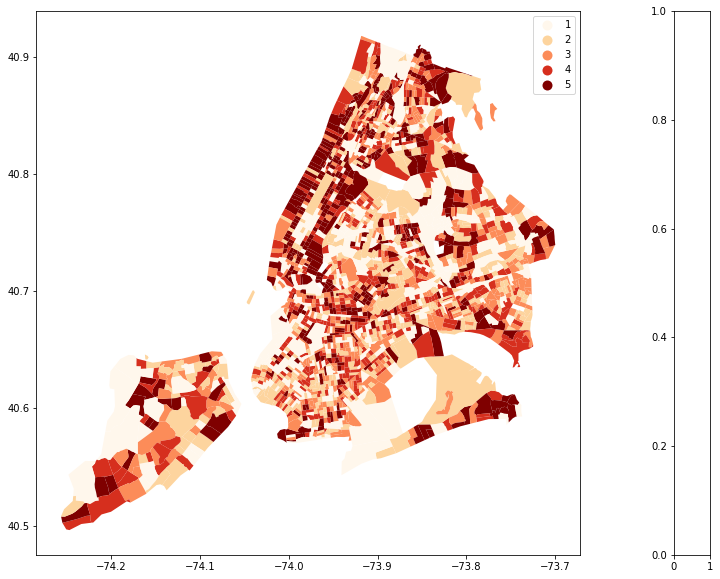

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

tracksNYC.plot(column='bin', ax=ax, legend=True, cax=cax, cmap='OrRd')

## Plot renter percentage

In [9]:
acs_renter = pd.read_csv('../data/neighborhood_char/acs_summary.csv')
acs_renter.head()

,GEO_ID,non_high_school_per,college_per,med_income,renter_num,renter_per,mid_rent,rent_35,total,latinx,white,black,asian,include
0,1400000US36081000100,1.8,79.5,142348.0,3642.0,87.7,3164.0,27.3,8830.0,8.2,58.8,3.9,22.8,1
1,1400000US36081000200,21.9,23.2,72813.0,415.0,44.4,1707.0,40.1,3208.0,70.0,11.7,1.2,16.1,0
2,1400000US36081000400,33.7,22.3,59423.0,633.0,53.3,1554.0,57.9,4583.0,67.0,4.4,2.8,23.2,1
3,1400000US36081000600,26.1,23.8,77407.0,388.0,40.2,1678.0,60.9,3690.0,64.6,10.4,3.3,20.5,0
4,1400000US36081000700,4.0,75.3,126935.0,1783.0,62.5,2223.0,31.3,6079.0,16.7,52.3,0.6,25.2,1


In [10]:
renterNYC = tracks.join(acs_renter.set_index("GEO_ID"), on="AFFGEOID", how = "right", rsuffix='r')

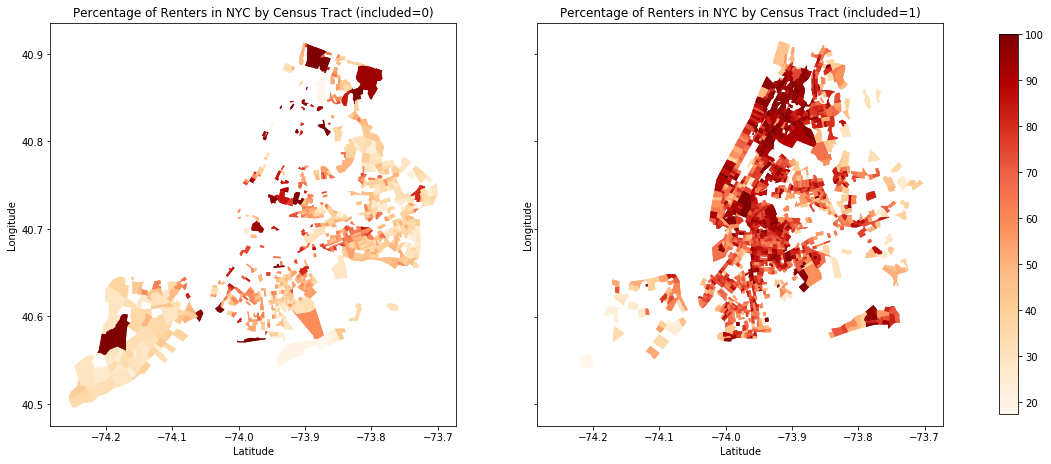

In [11]:
renterNYC['include'] = (renterNYC.renter_num>500)*1  # default threshold (UCLA) = 500
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for i in range(2):
    renterNYC[renterNYC['include']==0].plot(column='renter_per', ax=ax[0], cmap='OrRd');
    renterNYC[renterNYC['include']==1].plot(column='renter_per', ax=ax[1], cmap='OrRd');
    ax[i].set_title('Percentage of Renters in NYC by Census Tract (included={})'.format(i));
    ax[i].set_xlabel('Latitude');
    ax[i].set_ylabel('Longitude');
patch_col = ax[1].collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.7)
fig.savefig('../output/renter_percentage.png', bbox_inches = 'tight')

## Plot RVI

In [44]:
rvi = pd.read_csv('../data/RVI.csv')
rvi.head()

,GEO_ID,NAME,tract,total_population,CARES_exclusion_c,pay over 50,percentage-renters-less12k,ui_rate,unemployment rate,Risk of Job Displacement,...,asian,include,CARES_exclusion_c bin,pay over 50 bin,percentage-renters-less12k bin,ui_rate bin,unemployment rate bin,Risk of Job Displacement bin,sum_rankings,RVI
0,1400000US36061000100,"Census Tract 1, New York County, New York",36061000100,0,0.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1400000US36061000201,"Census Tract 2.01, New York County, New York",36061000201,2835,0.522764,0.23,0.399627,1.000000,4.05,0.295775,...,45.8,1,3.0,2.0,3.0,5.0,1.0,4.0,18.0,4
2,1400000US36061000202,"Census Tract 2.02, New York County, New York",36061000202,7764,0.217517,0.14,0.389513,0.930507,13.81,0.239418,...,21.0,1,2.0,1.0,3.0,5.0,3.0,3.0,17.0,4
3,1400000US36061000500,"Census Tract 5, New York County, New York",36061000500,0,0.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1400000US36061000600,"Census Tract 6, New York County, New York",36061000600,9731,0.113562,0.21,0.568819,1.000000,8.27,0.271813,...,56.6,1,1.0,2.0,4.0,5.0,2.0,3.0,17.0,4


In [45]:
rviNYC = tracks.join(rvi.set_index("GEO_ID"), on = "AFFGEOID", how = "right", rsuffix='d')
rviNYC.shape

(2167, 40)

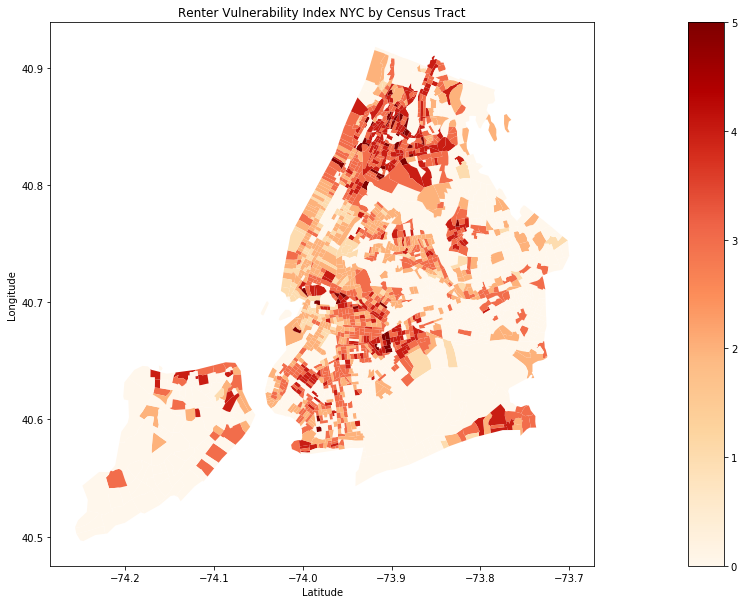

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
rviNYC.plot(column='RVI', ax=ax, legend=True, cax=cax, cmap='OrRd')
ax.set_title('Renter Vulnerability Index NYC by Census Tract');
ax.set_xlabel('Latitude');
ax.set_ylabel('Longitude');

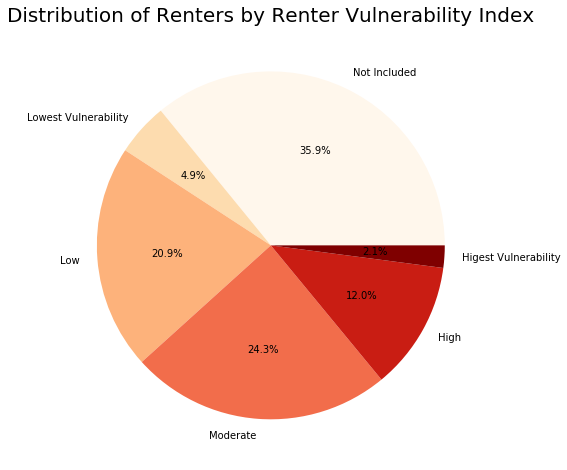

In [84]:
rvi_rename = {0:'Not Included', 1:'Lowest Vulnerability', 
              2:'Low', 3:'Moderate', 4:'High',  5: 'Higest Vulnerability'}
rviNYC.groupby('RVI').size().rename(rvi_rename).plot.pie(autopct='%1.1f%%', cmap='OrRd', 
                                                                          figsize=(8,8));
plt.title('Distribution of Renters by Renter Vulnerability Index',fontsize=20);
plt.ylabel('');

## Tables

In [113]:
cols = ['GEO_ID','total_population','CARES_exclusion_c','pay over 50','percentage-renters-less12k','ui_rate',
       'unemployment rate','Risk of Job Displacement','RVI']
demo_col = ['non_high_school_per', 'college_per', 'rent_35','latinx', 'white', 'black', 'asian']

rvi_table= rvi.loc[rvi.include==1,cols+demo_col]
rvi_table['ui_rate'] = 1 - rvi_table['ui_rate']
rvi_table['unemployment rate'] = rvi_table['unemployment rate'] / 100
rvi_table.head()

,GEO_ID,total_population,CARES_exclusion_c,pay over 50,percentage-renters-less12k,ui_rate,unemployment rate,Risk of Job Displacement,RVI,non_high_school_per,college_per,rent_35,latinx,white,black,asian
1,1400000US36061000201,2835,0.522764,0.23,0.399627,0.000000,0.0405,0.295775,4,51.8,11.3,36.6,44.6,4.5,5.3,45.8
2,1400000US36061000202,7764,0.217517,0.14,0.389513,0.069493,0.1381,0.239418,4,28.9,32.4,28.2,37.5,18.6,8.2,21.0
4,1400000US36061000600,9731,0.113562,0.21,0.568819,0.000000,0.0827,0.271813,4,55.4,15.1,38.5,30.0,4.7,2.3,56.6
5,1400000US36061000700,8809,0.070906,0.17,0.123174,0.259694,0.0307,0.039013,1,1.8,88.2,24.9,5.7,69.4,2.0,20.1
6,1400000US36061000800,8993,0.000000,0.41,0.399549,0.000000,0.0544,0.239092,3,55.7,20.3,57.1,4.7,8.2,0.1,84.9


In [114]:
# Table 2. Components of Renter Vulnerability Index
component_rename = {'CARES_exclusion_c': '% Excluded from CARES Act individual rebate',
                    'pay over 50': '% Renters spending 50% or more of income on housing',
                    'percentage-renters-less12k':'% Renters with less than $12K annually after housing cost',
                    'ui_rate': '% No unemployment insurance coverage',
                    'unemployment rate': '% Unemployed rate pre-COVID-19',
                    'Risk of Job Displacement': '% At-risk workers from COVID-19 job displacement'}
component = (rvi_table.groupby('RVI')[cols[2:-1]].mean() * 100).round(1).rename(columns=component_rename)
component['tract_count'] = rvi_table.groupby('RVI')['GEO_ID'].count()
component = component.T.rename(columns=rvi_rename).rename_axis(None, axis = 1)
component

,Lowest Vulnerability,Low,Moderate,High,Higest Vulnerability
% Excluded from CARES Act individual rebate,12.4,14.8,16.7,20.6,29.9
% Renters spending 50% or more of income on housing,16.0,24.7,32.2,38.5,42.0
% Renters with less than $12K annually after housing cost,12.6,23.6,36.6,47.8,56.5
% No unemployment insurance coverage,20.0,16.5,13.0,8.0,3.8
% Unemployed rate pre-COVID-19,3.6,5.1,7.7,10.9,17.1
% At-risk workers from COVID-19 job displacement,8.7,13.9,18.7,22.7,26.0
tract_count,106.0,453.0,526.0,259.0,45.0


In [115]:
# Table 3. Neighborhood Demographic and Socioeconomic Characteristics by Renter Vulnerability Index
demo_rename = {'non_high_school_per': '% Renters with less than high school education',
               'college_per': '% Renters with college education', 
               'rent_35': '% Renters with less than $35K',
               'latinx': '% Latinx renters',
               'white': '% White renters', 
               'black': '% Black renters', 
               'asian': '% Asian renters'}
demo = rvi_table[demo_col]
demo = (rvi_table.groupby('RVI')[demo_col].mean()).round(1).rename(columns=demo_rename)
demo['tract_count'] = rvi_table.groupby('RVI')['GEO_ID'].count()
demo = demo.T.rename(columns=rvi_rename).rename_axis(None, axis = 1)
demo

,Lowest Vulnerability,Low,Moderate,High,Higest Vulnerability
% Renters with less than high school education,5.3,13.3,22.4,29.4,35.2
% Renters with college education,72.2,48.5,30.0,17.8,12.4
% Renters with less than $35K,28.7,40.0,47.9,54.0,57.2
% Latinx renters,14.2,22.8,33.3,44.2,51.0
% White renters,62.8,44.1,23.8,13.7,9.7
% Black renters,2.6,3.6,4.9,6.3,6.7
% Asian renters,13.6,14.4,14.2,9.4,5.6
tract_count,106.0,453.0,526.0,259.0,45.0
